In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 12)

# Data from your document
data = {
    'TRUE': [0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 
             1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1],
    'Prob_L2': [0.0440, 0.9822, 0.8629, 0.9468, 0.2523, 0.0073, 0.2854, 0.3529, 0.7657, 
                0.9953, 0.0022, 0.9882, 0.9591, 0.1610, 0.9035, 0.9821, 0.0029, 0.2076,
                0.3646, 0.7244, 0.3511, 0.9850, 0.6936, 0.2737, 0.9752, 0.0000, 0.9678,
                0.9712, 0.3782, 0.0038, 0.2896, 0.8306, 0.0051, 0.3300, 1.0000, 0.9609,
                0.3091, 0.3714, 0.0088, 0.0045, 0.0656, 0.1489],
    'Prob_L1': [0.1687, 0.8951, 0.5527, 0.8978, 0.1454, 0.1402, 0.9246, 0.3794, 0.2562,
                0.9487, 0.0593, 0.5471, 0.8909, 0.1174, 0.9066, 0.8929, 0.1185, 0.5433,
                0.3557, 0.7844, 0.3619, 0.7800, 0.5241, 0.3708, 0.9017, 0.0252, 0.9037,
                0.9060, 0.3327, 0.0882, 0.3724, 0.9056, 0.2377, 0.3651, 0.9998, 0.9045,
                0.3402, 0.3954, 0.0341, 0.1279, 0.1340, 0.2936]
}

df = pd.DataFrame(data)

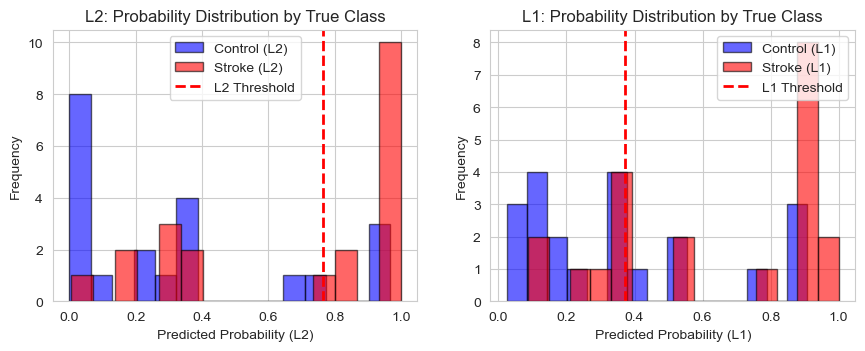

In [6]:
# Create figure with subplots
fig = plt.figure(figsize=(16, 12))

# 1. Probability Distribution by True Class
ax1 = plt.subplot(3, 3, 1)
df_stroke = df[df['TRUE'] == 1]
df_control = df[df['TRUE'] == 0]

ax1.hist(df_control['Prob_L2'], bins=15, alpha=0.6, label='Control (L2)', color='blue', edgecolor='black')
ax1.hist(df_stroke['Prob_L2'], bins=15, alpha=0.6, label='Stroke (L2)', color='red', edgecolor='black')
ax1.axvline(0.7657, color='red', linestyle='--', linewidth=2, label='L2 Threshold')
ax1.set_xlabel('Predicted Probability (L2)')
ax1.set_ylabel('Frequency')
ax1.set_title('L2: Probability Distribution by True Class')
ax1.legend()

ax2 = plt.subplot(3, 3, 2)
ax2.hist(df_control['Prob_L1'], bins=15, alpha=0.6, label='Control (L1)', color='blue', edgecolor='black')
ax2.hist(df_stroke['Prob_L1'], bins=15, alpha=0.6, label='Stroke (L1)', color='red', edgecolor='black')
ax2.axvline(0.3708, color='red', linestyle='--', linewidth=2, label='L1 Threshold')
ax2.set_xlabel('Predicted Probability (L1)')
ax2.set_ylabel('Frequency')
ax2.set_title('L1: Probability Distribution by True Class')
ax2.legend()


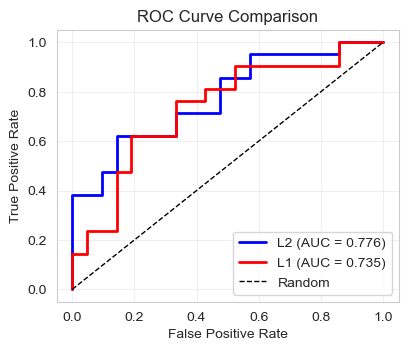

In [8]:
# 2. ROC Curves
ax3 = plt.subplot(3, 3, 3)
fpr_l2, tpr_l2, _ = roc_curve(df['TRUE'], df['Prob_L2'])
fpr_l1, tpr_l1, _ = roc_curve(df['TRUE'], df['Prob_L1'])
auc_l2 = auc(fpr_l2, tpr_l2)
auc_l1 = auc(fpr_l1, tpr_l1)

ax3.plot(fpr_l2, tpr_l2, 'b-', linewidth=2, label=f'L2 (AUC = {auc_l2:.3f})')
ax3.plot(fpr_l1, tpr_l1, 'r-', linewidth=2, label=f'L1 (AUC = {auc_l1:.3f})')
ax3.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
ax3.set_xlabel('False Positive Rate')
ax3.set_ylabel('True Positive Rate')
ax3.set_title('ROC Curve Comparison')
ax3.legend(loc='lower right')
ax3.grid(True, alpha=0.3)

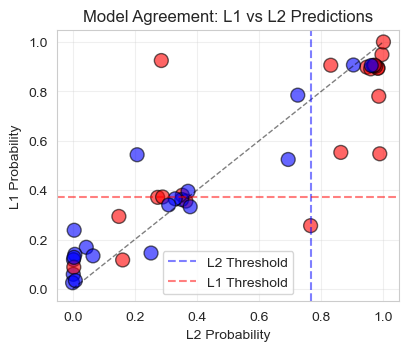

In [10]:
# 3. Scatter plot: L1 vs L2 probabilities
ax4 = plt.subplot(3, 3, 4)
colors = ['blue' if x == 0 else 'red' for x in df['TRUE']]
ax4.scatter(df['Prob_L2'], df['Prob_L1'], c=colors, alpha=0.6, s=100, edgecolors='black')
ax4.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.5)
ax4.axvline(0.7657, color='blue', linestyle='--', alpha=0.5, label='L2 Threshold')
ax4.axhline(0.3708, color='red', linestyle='--', alpha=0.5, label='L1 Threshold')
ax4.set_xlabel('L2 Probability')
ax4.set_ylabel('L1 Probability')
ax4.set_title('Model Agreement: L1 vs L2 Predictions')
ax4.legend()
ax4.grid(True, alpha=0.3)


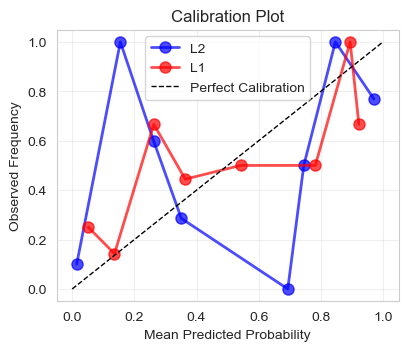

In [12]:
# 4. Calibration Plot
ax5 = plt.subplot(3, 3, 5)
n_bins = 10
for prob_col, color, label in [('Prob_L2', 'blue', 'L2'), ('Prob_L1', 'red', 'L1')]:
    bins = np.linspace(0, 1, n_bins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    bin_indices = np.digitize(df[prob_col], bins) - 1
    bin_indices = np.clip(bin_indices, 0, n_bins - 1)
    
    actual_probs = []
    predicted_probs = []
    for i in range(n_bins):
        mask = bin_indices == i
        if mask.sum() > 0:
            actual_probs.append(df[mask]['TRUE'].mean())
            predicted_probs.append(df[mask][prob_col].mean())
    
    ax5.plot(predicted_probs, actual_probs, 'o-', color=color, linewidth=2, 
             markersize=8, label=label, alpha=0.7)

ax5.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Perfect Calibration')
ax5.set_xlabel('Mean Predicted Probability')
ax5.set_ylabel('Observed Frequency')
ax5.set_title('Calibration Plot')
ax5.legend()
ax5.grid(True, alpha=0.3)

In [14]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 14)

# LASSO Features data
lasso_features = {
    'Feature': ['ethnicity_NON H/L', 'sbp_baseline', 'co2_tilt_pct', 
                'dm_patient_medical_history_YES', 'sbp_tilt', 'baseline_mean_hr_bp_baseline',
                'gender_M', 'co2_tilt', 'co2_hyper_pct', 'o2_base', 'siteo_mn_siteo_hr_mean',
                'dbp_supine_rebreathing', 'co2_reactivity_mcar', 'race_ASIAN', 
                'ethnicity_UNKNOWN', 'hrv_pnn50', 'mean_mcal_supine_rebreathing',
                'co2_supine_rebreathing', 'gait_walk_1_distance_m', 'gait_walk_2_distance_m',
                'ethnicity_NON-H/L'],
    'Coef': [0.4856, 0.3791, 0.3752, 0.3153, 0.1096, 0.0966, 0.0480, 0.0329, 0.0308,
             -0.0067, -0.0223, -0.0345, -0.0355, -0.1084, -0.1616, -0.2123, -0.2296,
             -0.2687, -0.3435, -0.6560, -0.7338],
    'OR': [1.6252, 1.4610, 1.4553, 1.3707, 1.1158, 1.1014, 1.0491, 1.0334, 1.0313,
           0.9933, 0.9779, 0.9661, 0.9652, 0.8973, 0.8508, 0.8087, 0.7948,
           0.7643, 0.7093, 0.5189, 0.4801]
}

# LASSO Selected Features (cleaned/final)
lasso_selected = {
    'Feature': ['ethnicity_NON H/L', 'sbp_baseline', 'co2_tilt_pct', 
                'dm_patient_medical_history_YES', 'sbp_tilt', 'baseline_mean_hr_bp_baseline',
                'gender_M', 'co2_tilt', 'co2_hyper_pct', 'o2_base', 'siteo_mn_siteo_hr_mean',
                'dbp_supine_rebreathing', 'co2_reactivity_mcar', 'race_ASIAN', 
                'ethnicity_UNKNOWN', 'hrv_pnn50', 'mean_mcal_supine_rebreathing',
                'co2_supine_rebreathing', 'gait_walk_1_distance_m', 'gait_walk_2_distance_m',
                'ethnicity_NON-H/L'],
    'Coef': [0.4865, 0.3797, 0.3756, 0.3148, 0.1092, 0.0973, 0.0485, 0.0324, 0.0303,
             -0.0067, -0.0218, -0.0342, -0.0358, -0.1084, -0.1616, -0.2121, -0.2295,
             -0.2694, -0.3300, -0.6700, -0.7337],
    'OR': [1.6267, 1.4619, 1.4558, 1.3699, 1.1154, 1.1022, 1.0497, 1.0329, 1.0308,
           0.9933, 0.9784, 0.9664, 0.9648, 0.8973, 0.8508, 0.8089, 0.7949,
           0.7639, 0.7189, 0.5117, 0.4801]
}

df_lasso = pd.DataFrame(lasso_features)
df_selected = pd.DataFrame(lasso_selected)

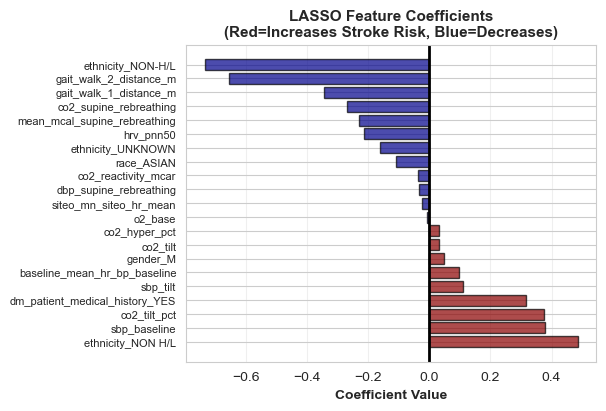

In [18]:
# Create figure with multiple subplots
fig = plt.figure(figsize=(18, 14))

# 1. Coefficient Waterfall/Bar Chart (Sorted by magnitude)
ax1 = plt.subplot(3, 3, 1)
colors = ['darkred' if x > 0 else 'darkblue' for x in df_lasso['Coef']]
bars = ax1.barh(range(len(df_lasso)), df_lasso['Coef'], color=colors, alpha=0.7, edgecolor='black')
ax1.set_yticks(range(len(df_lasso)))
ax1.set_yticklabels(df_lasso['Feature'], fontsize=8)
ax1.axvline(0, color='black', linewidth=2)
ax1.set_xlabel('Coefficient Value', fontsize=10, fontweight='bold')
ax1.set_title('LASSO Feature Coefficients\n(Red=Increases Stroke Risk, Blue=Decreases)', 
              fontsize=11, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')

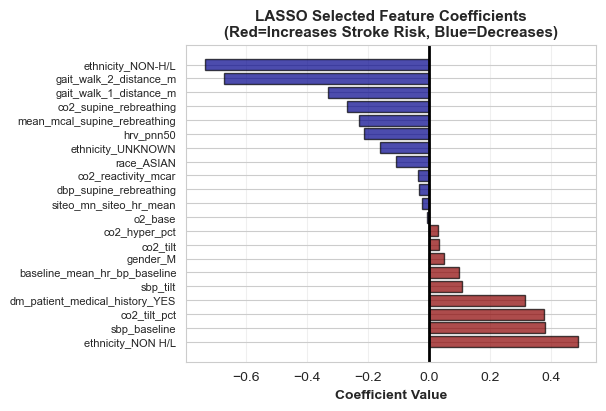

In [38]:
# Create figure with multiple subplots
fig = plt.figure(figsize=(18, 14))

# 1. Coefficient Waterfall/Bar Chart (Sorted by magnitude)
ax2 = plt.subplot(3, 3, 1)
colors = ['darkred' if x > 0 else 'darkblue' for x in df_selected['Coef']]
bars = ax2.barh(range(len(df_selected)), df_selected['Coef'], color=colors, alpha=0.7, edgecolor='black')
ax2.set_yticks(range(len(df_selected)))
ax2.set_yticklabels(df_selected['Feature'], fontsize=8)
ax2.axvline(0, color='black', linewidth=2)
ax2.set_xlabel('Coefficient Value', fontsize=10, fontweight='bold')
ax2.set_title('LASSO Selected Feature Coefficients\n(Red=Increases Stroke Risk, Blue=Decreases)', 
              fontsize=11, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

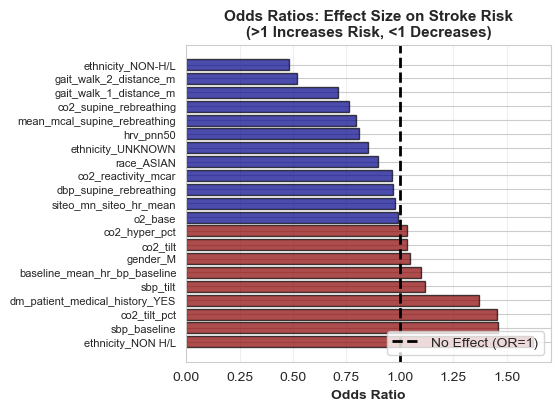

In [20]:
# 2. Odds Ratio Plot
ax2 = plt.subplot(3, 3, 2)
y_pos = range(len(df_lasso))
colors_or = ['darkred' if x > 1 else 'darkblue' for x in df_lasso['OR']]
ax2.barh(y_pos, df_lasso['OR'], color=colors_or, alpha=0.7, edgecolor='black')
ax2.axvline(1, color='black', linewidth=2, linestyle='--', label='No Effect (OR=1)')
ax2.set_yticks(y_pos)
ax2.set_yticklabels(df_lasso['Feature'], fontsize=8)
ax2.set_xlabel('Odds Ratio', fontsize=10, fontweight='bold')
ax2.set_title('Odds Ratios: Effect Size on Stroke Risk\n(>1 Increases Risk, <1 Decreases)', 
              fontsize=11, fontweight='bold')
ax2.legend(loc='lower right')
ax2.grid(True, alpha=0.3, axis='x')

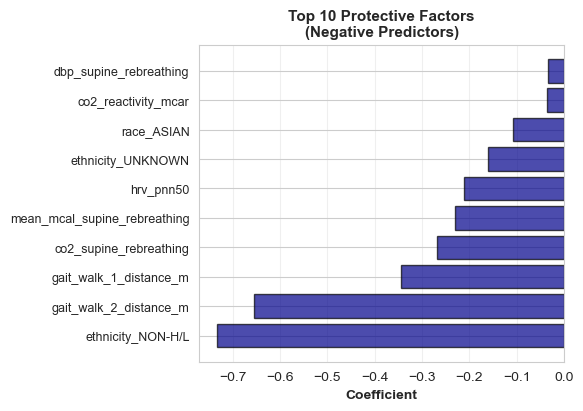

In [22]:
# 4. Top Protective Factors (Negative Coefficients)
ax4 = plt.subplot(3, 3, 4)
negative_features = df_lasso[df_lasso['Coef'] < 0].sort_values('Coef').head(10)
ax4.barh(range(len(negative_features)), negative_features['Coef'], 
         color='darkblue', alpha=0.7, edgecolor='black')
ax4.set_yticks(range(len(negative_features)))
ax4.set_yticklabels(negative_features['Feature'], fontsize=9)
ax4.set_xlabel('Coefficient', fontsize=10, fontweight='bold')
ax4.set_title('Top 10 Protective Factors\n(Negative Predictors)', 
              fontsize=11, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')

Text(0.5, 1.0, 'Feature Categories Distribution')

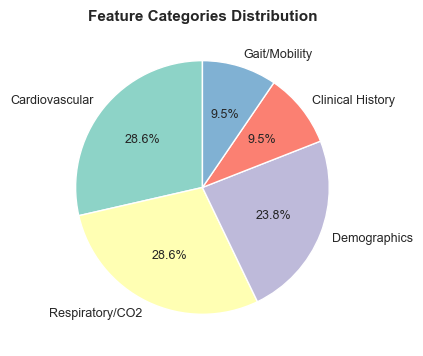

In [24]:
# 5. Feature Categories
ax5 = plt.subplot(3, 3, 5)
categories = []
for feat in df_lasso['Feature']:
    if 'ethnicity' in feat or 'race' in feat or 'gender' in feat:
        categories.append('Demographics')
    elif 'sbp' in feat or 'dbp' in feat or 'bp' in feat or 'hr' in feat or 'hrv' in feat:
        categories.append('Cardiovascular')
    elif 'co2' in feat or 'o2' in feat:
        categories.append('Respiratory/CO2')
    elif 'gait' in feat or 'walk' in feat:
        categories.append('Gait/Mobility')
    elif 'siteo' in feat or 'tilt' in feat:
        categories.append('Orthostatic')
    else:
        categories.append('Clinical History')

df_lasso['Category'] = categories
category_counts = df_lasso['Category'].value_counts()
colors_cat = plt.cm.Set3(range(len(category_counts)))
ax5.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', 
        colors=colors_cat, startangle=90, textprops={'fontsize': 9})
ax5.set_title('Feature Categories Distribution', fontsize=11, fontweight='bold')

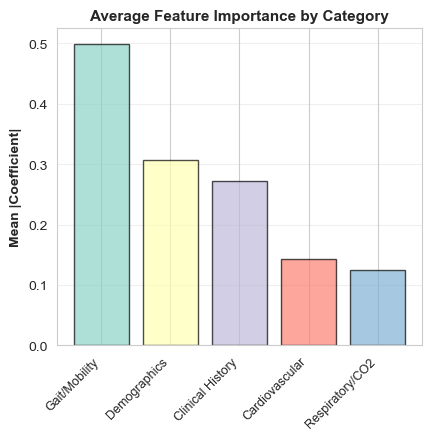

In [26]:
# 6. Coefficient Magnitude by Category
ax6 = plt.subplot(3, 3, 6)
df_lasso['Abs_Coef'] = df_lasso['Coef'].abs()
category_importance = df_lasso.groupby('Category')['Abs_Coef'].mean().sort_values(ascending=False)
bars = ax6.bar(range(len(category_importance)), category_importance.values, 
               color=plt.cm.Set3(range(len(category_importance))), alpha=0.7, edgecolor='black')
ax6.set_xticks(range(len(category_importance)))
ax6.set_xticklabels(category_importance.index, rotation=45, ha='right', fontsize=9)
ax6.set_ylabel('Mean |Coefficient|', fontsize=10, fontweight='bold')
ax6.set_title('Average Feature Importance by Category', fontsize=11, fontweight='bold')
ax6.grid(True, alpha=0.3, axis='y')

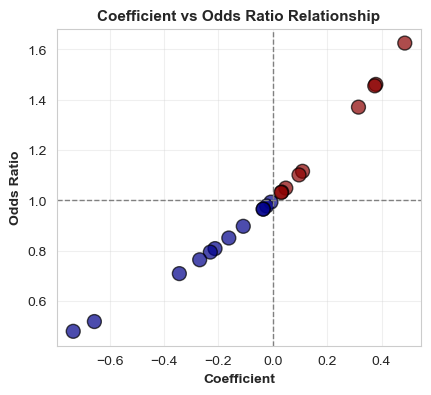

In [28]:
# 7. Coefficient vs Odds Ratio Scatter
ax7 = plt.subplot(3, 3, 7)
colors_scatter = ['darkred' if x > 0 else 'darkblue' for x in df_lasso['Coef']]
ax7.scatter(df_lasso['Coef'], df_lasso['OR'], c=colors_scatter, s=100, alpha=0.7, edgecolors='black')
ax7.axvline(0, color='gray', linestyle='--', linewidth=1)
ax7.axhline(1, color='gray', linestyle='--', linewidth=1)
ax7.set_xlabel('Coefficient', fontsize=10, fontweight='bold')
ax7.set_ylabel('Odds Ratio', fontsize=10, fontweight='bold')
ax7.set_title('Coefficient vs Odds Ratio Relationship', fontsize=11, fontweight='bold')
ax7.grid(True, alpha=0.3)

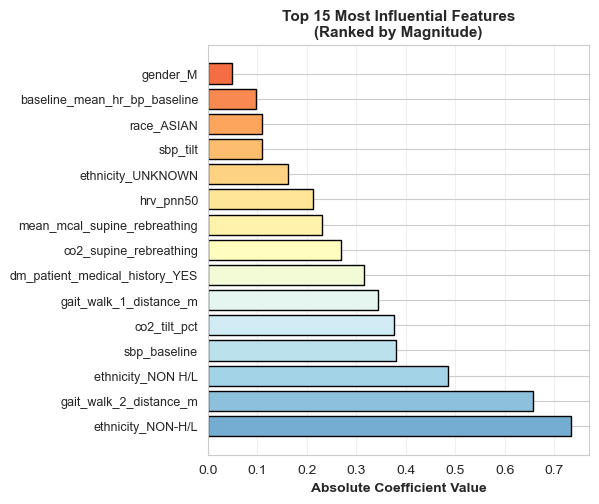

In [30]:
# 9. Feature Importance Ranking
ax9 = plt.subplot(3, 3, 9)
df_sorted = df_lasso.sort_values('Abs_Coef', ascending=False).head(15)
colors_rank = plt.cm.RdYlBu_r(np.linspace(0.2, 0.8, len(df_sorted)))
bars = ax9.barh(range(len(df_sorted)), df_sorted['Abs_Coef'], color=colors_rank, edgecolor='black')
ax9.set_yticks(range(len(df_sorted)))
ax9.set_yticklabels(df_sorted['Feature'], fontsize=9)
ax9.set_xlabel('Absolute Coefficient Value', fontsize=10, fontweight='bold')
ax9.set_title('Top 15 Most Influential Features\n(Ranked by Magnitude)', 
              fontsize=11, fontweight='bold')
ax9.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('lasso_feature_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
